In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# 2. Đọc file csv và gắng index với giá Close
data = pd.read_csv('../Dataset/CTG_2015_2023.csv')

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

data

df1=data.reset_index()['Close']

In [2]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [3]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.2 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]


In [4]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [5]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [6]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


In [7]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step, 1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - loss: 0.0266 - val_loss: 0.0151
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0021 - val_loss: 0.0037
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0016 - val_loss: 0.0058
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0015 - val_loss: 0.0070
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0013 - val_loss: 0.0050
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0013 - val_loss: 0.0044
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0013 - val_loss: 0.0048
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0012 - val_loss: 0.0037
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 8.6848e-04 - val_loss: 0.0020
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60m

In [9]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

y_pred_new = scaler.inverse_transform(y_pred.reshape(1, -1))
y_test_new = scaler.inverse_transform(np.array([ytest], dtype=np.float32))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_mda = calculate_mda(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MDA trên tập test là:', test_score_mda, '%')

RMSE trên tập test là: 678.98346
MAPE trên tập test là: 2.0625164732337 %
MDA trên tập test là: 48.77384196185286 %


In [11]:
# 13. Dự báo 30 ngày tiếp theo
x_input= test_data.reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):
    
    if(len(temp_input)>x_input.shape[1]):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.5062811]
400
1 day input [0.98024693 0.99012354 0.9407408  0.86666675 0.90370378 0.87901234
 0.96296298 0.95308652 0.94320991 0.90370378 0.90370378 0.92098773
 0.89876554 0.93827168 0.95802475 0.9753087  0.9851853  1.
 0.98765442 0.95802475 0.9506174  0.95802475 0.94320991 0.85432103
 0.90127514 0.88693409 0.85506511 0.7722056  0.75945801 0.73077585
 0.7722056  0.76105146 0.68456582 0.71643481 0.70368721 0.72440206
 0.69253307 0.68137892 0.69253307 0.70528066 0.73714972 0.75308421
 0.73236937 0.74352352 0.74033662 0.74671042 0.74511697 0.75786456
 0.76105146 0.74989731 0.75308421 0.74989731 0.7753925  0.75945801
 0.75627111 0.74989731 0.69890687 0.69890687 0.70050032 0.68137892
 0.65110332 0.64950987 0.68615927 0.67022478 0.67819203 0.67819203
 0.69731342 0.68137892 0.68934617 0.68615927 0.67181823 0.65110332
 0.64950987 0.66544443 0.67022478 0.67181823 0.66066408 0.65588374
 0.66385098 0.66703788 0.64472952 0.64313607 0.62560813 0.62560813
 0.60489329 0.57143078 0.59692604 0.590552

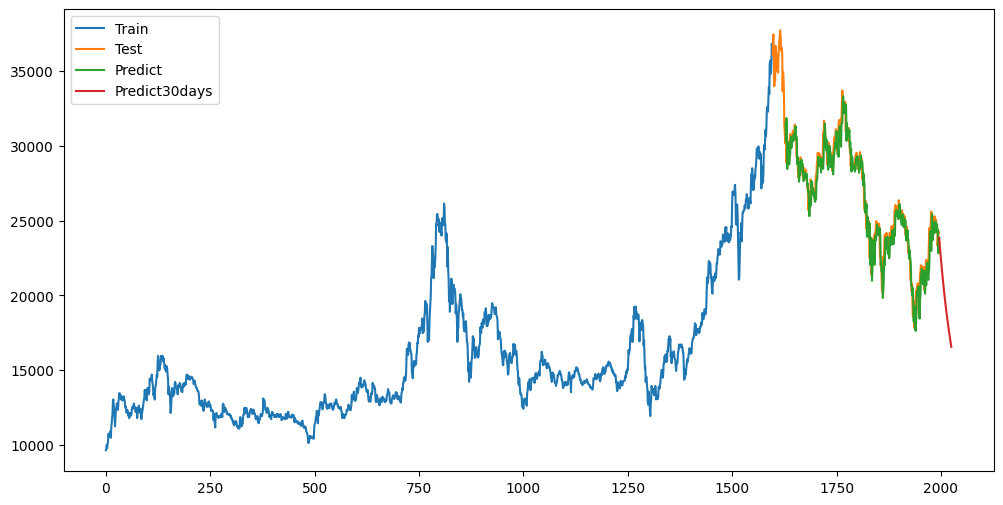

In [12]:
# 14.Vẽ hình
plt.figure(figsize=(12, 6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+31, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()